In [6]:
# === SETUP: Run this first! ===
import os
import sys

# Change to project root and add to Python path
notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir)  # Goes up one level from 'notebooks/'
os.chdir(project_root)
sys.path.insert(0, project_root)

print(f"Project root: {project_root}")
print(f"tsnn module path: {os.path.join(project_root, 'tsnn')}")

Project root: /Users/gremy/Code/TSNN
tsnn module path: /Users/gremy/Code/TSNN/tsnn


## Summary

- In narrow format, both lin reg and fully connected manage to capture a linear effect between features and target. A linear regression will always be better in this case since this is constrained to be exactly the function of the ground truth


In [7]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys
#sys.path.append('/Users/cyrilgarcia/notebooks/tsnn/')

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils
import torch.nn.functional as F
import math


plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
z = generators.Generator(1000, 100, 10)

In [124]:
%%time
z.generate_dataset(pct_zero_corr = 0.5,
                          split_conditional = 0.,
                          split_shift = 0.,
                          split_seasonal = 1.0,
                          low_corr=0.1, high_corr=0.2)

CPU times: user 768 ms, sys: 318 ms, total: 1.09 s
Wall time: 116 ms


In [125]:
z.get_dataloader()

### Simple benchmarks

In [126]:
# lasso benchmark
lasso = ml_benchmarks.LassoBenchmark()
lasso.fit(z.train)

In [127]:
lasso.score(z.train)

0.043510036103951384

In [128]:
# any custom benchmark
from sklearn.linear_model import LinearRegression
lr = ml_benchmarks.CustomBenchmark(LinearRegression())
lr.fit(z.train)

In [129]:
comp = benchmark_comparison.Comparator(models=[lasso, lr], model_names=['lasso', 'lr'])

In [130]:
comp.correl(z, mode='train')

,true,optimal,seasonal,lasso
optimal,0.1257,nan,nan,nan
seasonal,0.1257,1.0000,nan,nan
lasso,0.0435,0.3354,0.3354,nan
lr,0.0438,0.3348,0.3348,0.9941


In [131]:
comp.correl(z, mode='test')

,true,optimal,seasonal,lasso
optimal,0.1144,nan,nan,nan
seasonal,0.1144,1.0000,nan,nan
lasso,0.0332,0.3301,0.3301,nan
lr,0.0341,0.3299,0.3299,0.9941


## Torch benchmarks - narrow matrix (no cross-TS interactions)

### Fully connected

Equivalent to linear regression setup

In [132]:
z.get_dataloader(narrow=True)

In [133]:
from torch import nn
device = 'mps'

class NeuralNetwork(nn.Module):
    def __init__(self, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_f, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )
        
    def forward(self, x):
        pred = self.linear_relu_stack(x)
        return pred

In [134]:
m = NeuralNetwork(n_f=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]


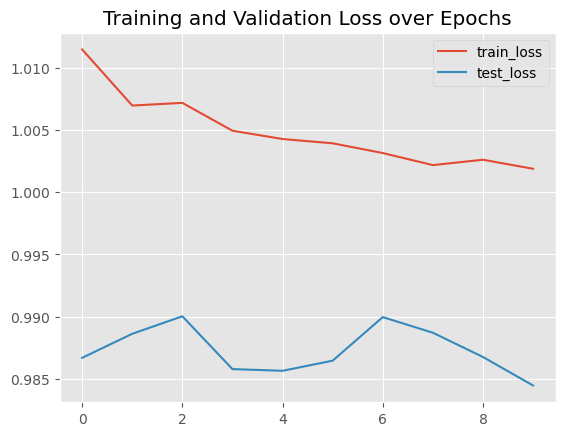

In [135]:
full_nn.fit(z.train, z.test, epochs=10)

In [136]:
comp = benchmark_comparison.Comparator(models=[full_nn, lasso], model_names=['nn', 'lasso'])

In [137]:
comp.correl(z, mode='train')

,true,optimal,seasonal,nn
optimal,0.1257,nan,nan,nan
seasonal,0.1257,1.0000,nan,nan
nn,0.0860,0.1583,0.1583,nan
lasso,0.0435,0.3354,0.3354,0.4293


In [138]:
comp.correl(z, mode='test')

,true,optimal,seasonal,nn
optimal,0.1144,nan,nan,nan
seasonal,0.1144,1.0000,nan,nan
nn,0.0179,0.1469,0.1469,nan
lasso,0.0332,0.3301,0.3301,0.4279


### LSTM

Equivalent to linear regression setup

In [139]:
z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)

In [140]:
from torch import nn
device = 'mps'

class LSTMModel(nn.Module):
    def __init__(self, n_f, hidden_dim=32):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_f, hidden_size=hidden_dim, batch_first=True, num_layers=2)
        self.decoder = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # x: (batch, T=10, n_f)
        _, (h, _) = self.encoder(x)
        out = self.decoder(h[-1]) 
        return out

In [141]:
m = LSTMModel(n_f=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_lstm = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.62s/it]


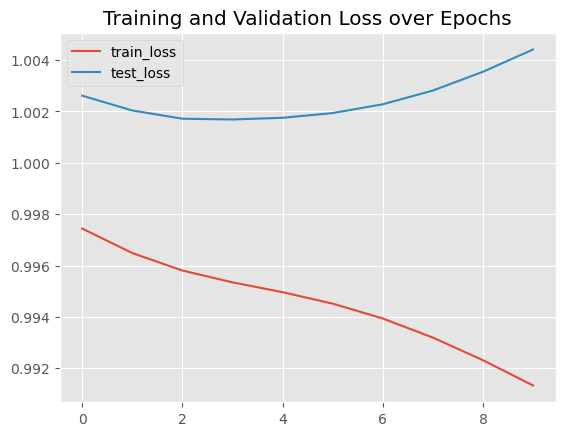

In [142]:
model_lstm.fit(z.train, test=z.test, epochs=10)

In [143]:
comp = benchmark_comparison.Comparator(models=[model_lstm, lasso], model_names=['lstm', 'lasso'])

In [144]:
comp.correl(z, mode='train')

,true,optimal,seasonal,lstm
optimal,0.1212,nan,nan,nan
seasonal,0.1212,1.0000,nan,nan
lstm,0.0936,0.1975,0.1975,nan
lasso,0.0421,0.3339,0.3339,0.5537


In [145]:
comp.correl(z, mode='test')

,true,optimal,seasonal,lstm
optimal,0.1251,nan,nan,nan
seasonal,0.1251,1.0000,nan,nan
lstm,0.0262,0.1888,0.1888,nan
lasso,0.0367,0.3336,0.3336,0.5586


### Transformer

In [146]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_f, n_rolling, d_model=64, nhead=4, num_layers=1, dropout=0.1):
        super().__init__()
        self.input_dim = n_f
        self.d_model = d_model

        # Linear projection of n_f features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            # nn.LayerNorm(d_model),
            nn.Linear(d_model, 1)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_f)
        # print(x.shape)
        B, n_rolling, n_f = x.shape

        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, src_key_padding_mask=mask, mask=causal_mask)

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        
        # encoded = self.encoder(x, mask=causal_mask)#[: x.size(1), : x.size(1)])
        # out = self.decoder(encoded[:, -1, :]).squeeze(-1)
        # print(out.shape)
        # 1/0
        return out.reshape((-1, 1))

In [147]:
m = TransformerEncoderModel(10, 5).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=0.001)

model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:20<00:00,  4.00s/it]


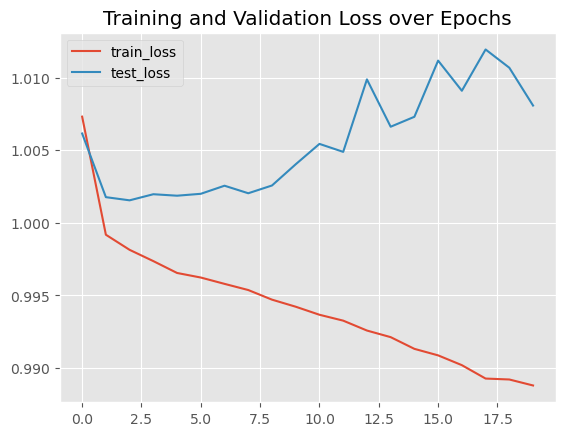

In [148]:
model_torch.fit(z.train, test=z.test, epochs=20)

In [149]:
#comp = benchmark_comparison.Comparator(models=[model_torch, lasso], model_names=['transformer', 'lasso'])
comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])

In [150]:
comp.correl(z, mode='train')

,true,optimal,seasonal
optimal,0.1212,nan,nan
seasonal,0.1212,1.0000,nan
model_torch,0.1250,0.1540,0.1540


In [151]:
comp.correl(z, mode='test')

,true,optimal,seasonal
optimal,0.1251,nan,nan
seasonal,0.1251,1.0000,nan
model_torch,0.0136,0.1346,0.1346


In [152]:
out_train = comp.correl(z, mode="train", return_values=True)

In [153]:
out_train.loc["model_torch", "optimal"]

0.1540121135893956

In [154]:
out_test = comp.correl(z, mode="test", return_values=True)

In [155]:
out_test.loc["model_torch", "optimal"]

0.1346472844530505

# Code to compare models

## Modifying d_model in the transformer

In [194]:
# Here we will modify the following parameters, first the noise level.

In [195]:
noise_level_low = [0.01, 0.02, 0.05, 0.1, 0.2]
noise_level_high = [0.02, 0.05, 0.1, 0.2, 0.5]

In [196]:
dic_z = {}

for i in range(len(noise_level_low)):
    z = generators.Generator(1000, 100, 10)
    z.generate_dataset(pct_zero_corr = 0.5,
                          split_conditional = 0.,
                          split_shift = 1.0,
                          split_seasonal = 0.,
                          low_corr=noise_level_low[i], high_corr=noise_level_high[i])
    #z.get_dataloader(narrow=True)
    z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)
    name_z = "z" + str(i)
    dic_z[name_z] = z
    

In [197]:
dic_z

{'z0': <tsnn.generators.generators.Generator at 0x381ff8c50>,
 'z1': <tsnn.generators.generators.Generator at 0x382002710>,
 'z2': <tsnn.generators.generators.Generator at 0x387b3f9d0>,
 'z3': <tsnn.generators.generators.Generator at 0x387b3fa50>,
 'z4': <tsnn.generators.generators.Generator at 0x387b3ffd0>}

In [198]:
# Next let's give ourselves a sequence of models, say the transformer where we modify one parameter.

In [199]:
d_model_values = [4, 8, 16, 32, 64, 128]

In [200]:
dic_models = {}

for i in range(len(d_model_values)):
    m = TransformerEncoderModel(10, 5, d_model=d_model_values[i]).to(device)
    #m = TransformerEncoderModel(10, 5).to(device)
    model_name = "model" + str(i)
    dic_models[model_name] = m  


In [201]:
#dic_models

In [202]:
# Let's now compute the performance of all the models.

In [203]:
correls_IS = np.zeros((len(noise_level_low), len(d_model_values)))
correls_OOS = np.zeros((len(noise_level_low), len(d_model_values)))

In [204]:
correls_OOS

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [205]:
# index1 = 0
# index2 = 0

# name_z = "z" + str(index1)
# model_name = "model" + str(index2)

# z = dic_z[name_z]
# m = dic_models[model_name]

# optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
# model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
# model_torch.fit(z.train, test=z.test, epochs=20)

# comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])

# out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
# out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]


In [206]:
correls_IS = np.zeros((len(noise_level_low), len(d_model_values)))
correls_OOS = np.zeros((len(noise_level_low), len(d_model_values)))


In [372]:
# Let's now run the above on all the indexes and see what we get

for index1 in range(len(noise_level_low)):
    for index2 in range(len(d_model_values)):

        name_z = "z" + str(index1)
        model_name = "model" + str(index2)
        
        z = dic_z[name_z]
        m = dic_models[model_name]
        
        optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
        model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
        model_torch.fit(z.train, test=z.test, epochs=20)
        
        comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
        out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
        out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

        correls_IS[index1][index2] = out_train
        correls_OOS[index1][index2] = out_test

        print(model_name, name_z, " done")



In [208]:
correls_IS

array([[0.38239117, 0.86359712, 0.66331768, 0.4895663 , 0.4152386 ,
        0.68714794],
       [0.91925489, 0.91813901, 0.75828495, 0.52665683, 0.63635329,
        0.91113658],
       [0.97191664, 0.9661525 , 0.94424783, 0.86417348, 0.82325717,
        0.97532495],
       [0.99243349, 0.99255749, 0.99255038, 0.98681223, 0.98156959,
        0.99578811],
       [0.99550487, 0.99770306, 0.99758824, 0.997629  , 0.99753996,
        0.99860731]])

In [209]:
correls_OOS

array([[0.38092994, 0.8635059 , 0.65372892, 0.49086114, 0.4181185 ,
        0.68330802],
       [0.91747054, 0.91776331, 0.75873146, 0.5350828 , 0.64565062,
        0.90931728],
       [0.97173932, 0.96581465, 0.94565899, 0.8675428 , 0.82761   ,
        0.97493392],
       [0.99286259, 0.99264952, 0.99249299, 0.98817385, 0.98194672,
        0.99599603],
       [0.99561628, 0.99775135, 0.99758714, 0.99764613, 0.9976126 ,
        0.99867228]])

In [211]:
print(torch.backends.mps.is_available()) 
print(torch.backends.mps.is_built())

True
True


In [212]:
# Ok so let's put this in an array and display it correctly.

In [ ]:
# for index1 in range(len(noise_level_low)):
#     for index2 in range(len(d_model_values)):

In [213]:
dic_z.keys()

dict_keys(['z0', 'z1', 'z2', 'z3', 'z4'])

In [214]:
dic_models.keys()

dict_keys(['model0', 'model1', 'model2', 'model3', 'model4', 'model5'])

In [231]:
pd_correls_IS = pd.DataFrame(correls_IS, index=["min_correl_" + str(x) for x in noise_level_low],
                             columns=["d_model_" + str(x) for x in d_model_values])
pd_correls_OOS = pd.DataFrame(correls_OOS, index=["min_correl_" + str(x) for x in noise_level_low],
                            columns=["d_model_" + str(x) for x in d_model_values])

In [238]:
print("Correlation IS between transformer prediction and optimal y for different levels of correl and different values of d_model.")
pd_correls_IS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

Correlation IS between transformer prediction and optimal y for different levels of correl and different values of d_model.


,d_model_4,d_model_8,d_model_16,d_model_32,d_model_64,d_model_128
min_correl_0.01,0.3824,0.8636,0.6633,0.4896,0.4152,0.6871
min_correl_0.02,0.9193,0.9181,0.7583,0.5267,0.6364,0.9111
min_correl_0.05,0.9719,0.9662,0.9442,0.8642,0.8233,0.9753
min_correl_0.1,0.9924,0.9926,0.9926,0.9868,0.9816,0.9958
min_correl_0.2,0.9955,0.9977,0.9976,0.9976,0.9975,0.9986


In [236]:
pd_correls_OOS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

,d_model_4,d_model_8,d_model_16,d_model_32,d_model_64,d_model_128
min_correl_0.01,0.3809,0.8635,0.6537,0.4909,0.4181,0.6833
min_correl_0.02,0.9175,0.9178,0.7587,0.5351,0.6457,0.9093
min_correl_0.05,0.9717,0.9658,0.9457,0.8675,0.8276,0.9749
min_correl_0.1,0.9929,0.9926,0.9925,0.9882,0.9819,0.9960
min_correl_0.2,0.9956,0.9978,0.9976,0.9976,0.9976,0.9987


In [239]:
# Ok these results are very strange... there is a minimum in the middle ????

In [240]:
# Let's try a few other parameter modifications.

## Changing the number of heads

In [262]:
#noise_level_low = [0.01, 0.02, 0.05, 0.1, 0.2]
#noise_level_high = [0.02, 0.05, 0.1, 0.2, 0.5]
noise_level_low = [0.01, 0.02, 0.05]
noise_level_high = [0.02, 0.05, 0.1]

In [263]:
dic_z = {}

for i in range(len(noise_level_low)):
    z = generators.Generator(1000, 100, 10)
    z.generate_dataset(pct_zero_corr = 0.5,
                          split_conditional = 0.,
                          split_shift = 1.0,
                          split_seasonal = 0.,
                          low_corr=noise_level_low[i], high_corr=noise_level_high[i])
    #z.get_dataloader(narrow=True)
    z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)
    name_z = "z" + str(i)
    dic_z[name_z] = z
    

In [264]:
dic_z

{'z0': <tsnn.generators.generators.Generator at 0x38264ba50>,
 'z1': <tsnn.generators.generators.Generator at 0x339d90090>,
 'z2': <tsnn.generators.generators.Generator at 0x339da5510>}

In [265]:
# Next let's give ourselves a sequence of models, say the transformer where we modify one parameter.

In [266]:
nhead_values = [2,4,8]

In [267]:
dic_models = {}

for i in range(len(nhead_values)):
    m = TransformerEncoderModel(10, 5, nhead=nhead_values[i]).to(device)
    #m = TransformerEncoderModel(10, 5).to(device)
    model_name = "model" + str(i)
    dic_models[model_name] = m  


In [268]:
#dic_models

In [269]:
# Let's now compute the performance of all the models.

In [270]:
heads_correls_IS = np.zeros((len(noise_level_low), len(nhead_values)))
heads_correls_OOS = np.zeros((len(noise_level_low), len(nhead_values)))

In [373]:
# Let's now run the above on all the indexes and see what we get

for index1 in range(len(noise_level_low)):
    for index2 in range(len(nhead_values)):

        name_z = "z" + str(index1)
        model_name = "model" + str(index2)
        
        z = dic_z[name_z]
        m = dic_models[model_name]
        
        optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
        model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
        model_torch.fit(z.train, test=z.test, epochs=20)
        
        comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
        out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
        out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

        heads_correls_IS[index1][index2] = out_train
        heads_correls_OOS[index1][index2] = out_test

        print(model_name, name_z, " done")



In [274]:
pd_heads_correls_IS = pd.DataFrame(heads_correls_IS, index=["min_correl_" + str(x) for x in noise_level_low],
                             columns=["nhead_" + str(x) for x in nhead_values])
pd_heads_correls_OOS = pd.DataFrame(heads_correls_OOS, index=["min_correl_" + str(x) for x in noise_level_low],
                             columns=["nhead_" + str(x) for x in nhead_values])

In [277]:
print("Correlation IS between transformer prediction and optimal y for different levels of correl and different values of nhead.")
pd_heads_correls_IS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

Correlation IS between transformer prediction and optimal y for different levels of correl and different values of nhead.


,nhead_2,nhead_4,nhead_8
min_correl_0.01,0.2766,0.4158,0.2627
min_correl_0.02,0.6075,0.5495,0.4478
min_correl_0.05,0.9282,0.9216,0.7609


In [278]:
pd_heads_correls_OOS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

,nhead_2,nhead_4,nhead_8
min_correl_0.01,0.2774,0.4146,0.2655
min_correl_0.02,0.6105,0.5472,0.4583
min_correl_0.05,0.9266,0.9235,0.7639


In [279]:
# Here it seems that nhead=4 is the best choice, which is what we had chosen, this is good!

## Modifying dropout

In [280]:
# Here let's modify the dropout parameter.

In [297]:
#noise_level_low = [0.01, 0.02, 0.05, 0.1, 0.2]
#noise_level_high = [0.02, 0.05, 0.1, 0.2, 0.5]
noise_level_low = [0.01, 0.02, 0.05]
noise_level_high = [0.02, 0.05, 0.1]

In [298]:
dic_z = {}

for i in range(len(noise_level_low)):
    z = generators.Generator(1000, 100, 10)
    z.generate_dataset(pct_zero_corr = 0.5,
                          split_conditional = 0.,
                          split_shift = 1.0,
                          split_seasonal = 0.,
                          low_corr=noise_level_low[i], high_corr=noise_level_high[i])
    #z.get_dataloader(narrow=True)
    z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)
    name_z = "z" + str(i)
    dic_z[name_z] = z
    

In [299]:
dic_z

{'z0': <tsnn.generators.generators.Generator at 0x33aea2650>,
 'z1': <tsnn.generators.generators.Generator at 0x3399d4dd0>,
 'z2': <tsnn.generators.generators.Generator at 0x3884e5090>}

In [300]:
# Next let's give ourselves a sequence of models, say the transformer where we modify one parameter.

In [302]:
dropout_values = [0, 0.05, 0.1, 0.2, 0.5]

In [303]:
dic_models = {}

for i in range(len(dropout_values)):
    m = TransformerEncoderModel(10, 5, dropout=dropout_values[i]).to(device)
    #m = TransformerEncoderModel(10, 5).to(device)
    model_name = "model" + str(i)
    dic_models[model_name] = m  


In [304]:
dic_models.keys()

dict_keys(['model0', 'model1', 'model2', 'model3', 'model4'])

In [305]:
# Let's now compute the performance of all the models.

In [307]:
dropout_correls_IS = np.zeros((len(noise_level_low), len(dropout_values)))
dropout_correls_OOS = np.zeros((len(noise_level_low), len(dropout_values)))

In [374]:
# Let's now run the above on all the indexes and see what we get

for index1 in range(len(noise_level_low)):
    for index2 in range(len(dropout_values)):

        name_z = "z" + str(index1)
        model_name = "model" + str(index2)
        
        z = dic_z[name_z]
        m = dic_models[model_name]
        
        optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
        model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
        model_torch.fit(z.train, test=z.test, epochs=20)
        
        comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
        out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
        out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

        dropout_correls_IS[index1][index2] = out_train
        dropout_correls_OOS[index1][index2] = out_test

        print(model_name, name_z, " done")



In [309]:
pd_dropout_correls_IS = pd.DataFrame(dropout_correls_IS, index=["min_correl_" + str(x) for x in noise_level_low],
                             columns=["dropout_" + str(x) for x in dropout_values])
pd_dropout_correls_OOS = pd.DataFrame(dropout_correls_OOS, index=["min_correl_" + str(x) for x in noise_level_low],
                             columns=["dropout_" + str(x) for x in dropout_values])

In [310]:
print("Correlation IS between transformer prediction and optimal y for different levels of correl and different values of dropout.")
pd_dropout_correls_IS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

Correlation IS between transformer prediction and optimal y for different levels of correl and different values of dropout.


,dropout_0,dropout_0.05,dropout_0.1,dropout_0.2,dropout_0.5
min_correl_0.01,0.2653,0.2396,0.3369,0.5698,0.7226
min_correl_0.02,0.4844,0.5344,0.7244,0.9395,0.9721
min_correl_0.05,0.5898,0.7921,0.9340,0.9780,0.9856


In [311]:
pd_dropout_correls_OOS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

,dropout_0,dropout_0.05,dropout_0.1,dropout_0.2,dropout_0.5
min_correl_0.01,0.2747,0.2320,0.3313,0.5704,0.7215
min_correl_0.02,0.5027,0.5348,0.7249,0.9398,0.9720
min_correl_0.05,0.5930,0.7918,0.9335,0.9777,0.9852


In [312]:
# Clearly here we see that high dropout greatly increases the correlation when there is a lot of noise.

## Adding weight decay

In [348]:
# Another way to perform regularization is to add weight decay in the optimizer, this works with AdamW
# We perform this below

In [349]:
#noise_level_low = [0.01, 0.02, 0.05, 0.1, 0.2]
#noise_level_high = [0.02, 0.05, 0.1, 0.2, 0.5]
noise_level_low = [0.01, 0.02, 0.05]
noise_level_high = [0.02, 0.05, 0.1]

In [350]:
dic_z = {}

for i in range(len(noise_level_low)):
    z = generators.Generator(1000, 100, 10)
    z.generate_dataset(pct_zero_corr = 0.5,
                          split_conditional = 0.,
                          split_shift = 1.0,
                          split_seasonal = 0.,
                          low_corr=noise_level_low[i], high_corr=noise_level_high[i])
    #z.get_dataloader(narrow=True)
    z.get_dataloader(n_rolling=5, narrow=True, train_test_split=True, shuffle=False)
    name_z = "z" + str(i)
    dic_z[name_z] = z
    

In [351]:
dic_z

{'z0': <tsnn.generators.generators.Generator at 0x33a275ed0>,
 'z1': <tsnn.generators.generators.Generator at 0x33a8d2cd0>,
 'z2': <tsnn.generators.generators.Generator at 0x387ad7510>}

In [352]:
m = TransformerEncoderModel(10, 5, dropout=0.1).to(device)

In [353]:
# Let's now compute the performance of all the models.

In [354]:
weidecay_values = [1e-4, 1e-3, 1e-2]

In [355]:
weidecay_values

[0.0001, 0.001, 0.01]

In [356]:
weidecay_correls_IS = np.zeros((len(noise_level_low), len(weidecay_values) +1))
weidecay_correls_OOS = np.zeros((len(noise_level_low), len(weidecay_values) +1))

In [357]:
weidecay_correls_OOS.shape

(3, 4)

In [376]:
# Let's now run the above on all the indexes and see what we get

for index1 in range(len(noise_level_low)):
    index2 = 0 

    name_z = "z" + str(index1)
    model_name = "model" + str(index2)
    
    z = dic_z[name_z]
    m = TransformerEncoderModel(10, 5, dropout=0.1).to(device)
    optimizer = torch.optim.AdamW(
        m.parameters(),
        lr=0.001,
    )
    
    model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
    model_torch.fit(z.train, test=z.test, epochs=20)
    
    comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
    
    out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
    out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

    weidecay_correls_IS[index1][index2] = out_train
    weidecay_correls_OOS[index1][index2] = out_test

    print(model_name, name_z, " done")

In [375]:

for index1 in range(len(noise_level_low)):
    for index2 in range(1, len(weidecay_values) +1):

        name_z = "z" + str(index1)
        model_name = "model" + str(index2)
        
        z = dic_z[name_z]
        m = TransformerEncoderModel(10, 5, dropout=0.1).to(device)
        optimizer = torch.optim.AdamW(
            m.parameters(),
            lr=0.001,
            weight_decay=weidecay_values[index2 - 1]   # ← Recommended for noisy time-series
        )
        model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
        model_torch.fit(z.train, test=z.test, epochs=20)
        
        comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
        out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
        out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

        weidecay_correls_IS[index1][index2] = out_train
        weidecay_correls_OOS[index1][index2] = out_test

        print(model_name, name_z, " done")



In [368]:
pd_weidecay_correls_IS = pd.DataFrame(weidecay_correls_IS, index=["min_correl_" + str(x) for x in noise_level_low],
                             columns=["weidecay_" + str(x) for x in [0] + weidecay_values])

pd_weidecay_correls_OOS = pd.DataFrame(weidecay_correls_OOS, index=["min_correl_" + str(x) for x in noise_level_low],
                             columns=["weidecay_" + str(x) for x in [0] + weidecay_values])


In [369]:
print("Correlation IS between transformer prediction and optimal y for different levels of correl and different values of weight decay.")
pd_weidecay_correls_IS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

Correlation IS between transformer prediction and optimal y for different levels of correl and different values of weight decay.


,weidecay_0,weidecay_0.0001,weidecay_0.001,weidecay_0.01
min_correl_0.01,0.3707,0.3719,0.4281,0.4704
min_correl_0.02,0.6697,0.5566,0.6556,0.5682
min_correl_0.05,0.9012,0.9082,0.8976,0.9167


In [370]:
pd_weidecay_correls_OOS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

,weidecay_0,weidecay_0.0001,weidecay_0.001,weidecay_0.01
min_correl_0.01,0.3741,0.3808,0.4301,0.4697
min_correl_0.02,0.6702,0.5559,0.6476,0.5672
min_correl_0.05,0.9047,0.9086,0.8992,0.9157


In [371]:
# This weight decay seems to help when there is really a lot of noise.